#**Mounting**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

os.chdir('/content/drive/My Drive/Colab Notebooks/ML_class/attention')
%pwd

'/content/drive/My Drive/Colab Notebooks/ML_class/attention'

# 1. Attention

# 1.1. What is Attention? 

- In psychology, attention is the cognitive process of selectively concentrating on one or a few things while ignoring others.





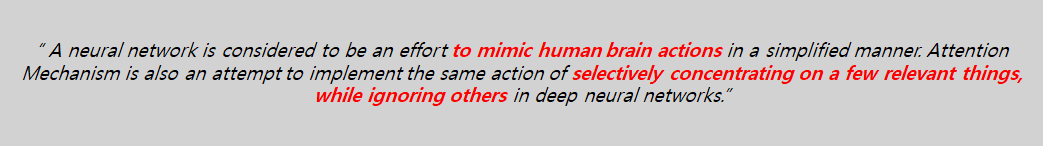


- **Focusing on specific parts of the input** has been applied in Deep Learning, for speech recognition, translation, reasoning, and visual identification of objects.



# 1.2. Attention for RNNs

- Recurrent Neural Networks (RNNs) model sequential data and have been successfuly used for many tasks such as text classification, image captioning, time-series prediction etc. 

- Improved RNN models such as Long Short-Term Memory networks (LSTMs) enable training on long sequences overcoming problems like vanishing gradients. however, even the more complex models have their limitations and researchers had a hard time developing high quality models when working with long data sequences. An example of such a task is machine translation, where the RNN has to model connections between long input and output sentences comprising of doesens of words.

- Attention is a mechnism combined in the RNN and allowing it to focus on certain parts of the input sequence when predicting certain part of the output sequence, enabling easier learning and of higher quality. Combination of attention mechanisms enabled improved performence in many tasks making it an integral part in modern RNN networks. 




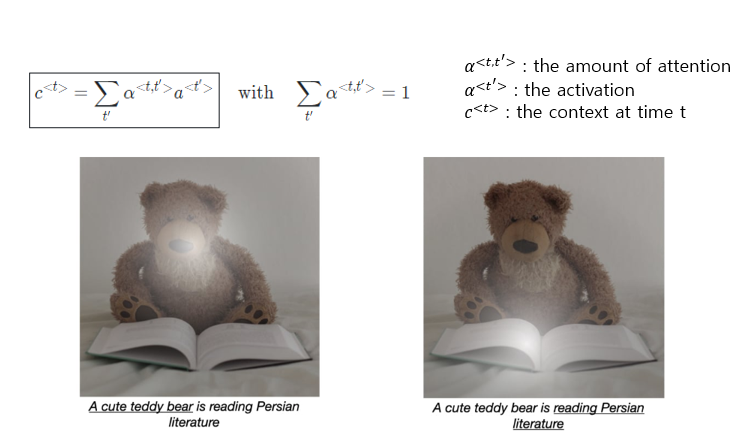

#2. Text Classification 
 
- We will cover following two different models.
  - RNN
  - LSTM
  - LSTM + Attention  

- RNN models are mostly used in the fields of natural language processing and speech recognition. In this class, we will implement many to one RNNs for the text classification task.    



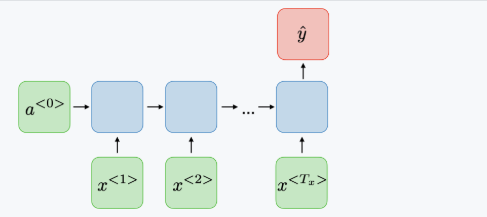


- We are focussing on the sentiment Analysis on IMBD dataset. 
 - IMDB movie review sentiment classification dataset 
   - This is a dataset of 25,000 movies reviews from IMDB, labeled by sentiment (positive/negative). Reviews have been preprocessed, and each review is encoded as a list of word indexes (integers). For convenience, words are indexed by overall frequency in the dataset, so that for instance the integer "3" encodes the 3rd most frequent word in the data. This allows for quick filtering operations such as: "only consider the top 10,000 most common words, but eliminate the top 20 most common words".
   - For more details : https://ai.stanford.edu/~amaas/data/sentiment/


## 2.0. Load dataset

For text classificaition, we load the dataset from torchtext and pretrained Word Embeddings (GloVe).
 - For more details :
  - https://pytorch.org/text/
 

In [0]:
import os
import sys
import torch
from torch.nn import functional as F
import numpy as np
from torchtext import data
from torchtext import datasets
from torchtext.vocab import Vectors, GloVe

def load_dataset(test_sen=None):

    """
    tokenizer : Breaks sentences into a list of words. If sequential=False, no tokenization is applied
    Field : A class that stores information about the way of preprocessing
    fix_length : An important property of TorchText is that we can let the input to be variable length, and TorchText will
                 dynamically pad each sequence to the longest sequence in that "batch". But here we are using fi_length which
                 will pad each sequence to have a fix length of 200.
                 
    build_vocab : It will first make a vocabulary or dictionary mapping all the unique words present in the train_data to an
                  idx and then after it will use GloVe word embedding to map the index to the corresponding word embedding.
                  
    vocab.vectors : This returns a torch tensor of shape (vocab_size x embedding_dim) containing the pre-trained word embeddings.
    BucketIterator : Defines an iterator that batches examples of similar lengths together to minimize the amount of padding needed.
    
    """
    
    tokenize = lambda x: x.split()
    TEXT = data.Field(sequential=True, tokenize=tokenize, lower=True, include_lengths=True, batch_first=True, fix_length=200)
    LABEL = data.LabelField()
    train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

    print("IMDB training data length:", train_data.__len__())
    print("IMDB test data length:", test_data.__len__())

    TEXT.build_vocab(train_data, vectors=GloVe(name='6B', dim=300))
    LABEL.build_vocab(train_data)

    word_embeddings = TEXT.vocab.vectors
    print ("\nLength of Text Vocabulary: " + str(len(TEXT.vocab)))
    print ("Vector size of Text Vocabulary: ", TEXT.vocab.vectors.size())
    print ("Label Length: " + str(len(LABEL.vocab)))

    train_data, valid_data = train_data.split() 
    train_iter, valid_iter, test_iter = data.BucketIterator.splits((train_data, valid_data, test_data), batch_size=32, sort_key=lambda x: len(x.text), repeat=False, shuffle=True)

    print("IMDB training data length:", train_data.__len__())
    print("IMDB validation data length:", valid_data.__len__())

    vocab_size = len(TEXT.vocab)
 
    return TEXT, vocab_size, word_embeddings, train_iter, valid_iter, test_iter


In [0]:
TEXT, vocab_size, word_embeddings, train_iter, valid_iter, test_iter = load_dataset()  

In [0]:
temp_batch = next(iter(train_iter))
print(temp_batch)
print("text[0](indices):", temp_batch.text[0].size())
print("text[1](Length) :", temp_batch.text[1].size())
print("label :", temp_batch.label.size())
print("text:", temp_batch.text)
print("label:", temp_batch.label)
temp_example = next(iter(temp_batch.dataset))
print(temp_example)


[torchtext.data.batch.Batch of size 32]
	[.text]:('[torch.LongTensor of size 32x200]', '[torch.LongTensor of size 32]')
	[.label]:[torch.LongTensor of size 32]
text[0](indices): torch.Size([32, 200])
text[1](Length) : torch.Size([32])
label : torch.Size([32])
text: (tensor([[   10,    24,     7,  ...,     1,     1,     1],
        [ 1006,  2176,     4,  ...,   136,  5105,   474],
        [    2,   116,   174,  ...,     3, 15958,    13],
        ...,
        [ 5996,    12,     6,  ...,     1,     1,     1],
        [    6, 89394,    20,  ...,     1,     1,     1],
        [    9,    14,  1350,  ...,  2752,    71,    76]]), tensor([ 71, 200, 200, 143, 160, 141, 200, 200, 122, 200, 149,  95, 108, 200,
         92, 200, 108, 172, 200,  79,  44, 185, 171, 200, 131, 124, 200, 200,
        200,  51, 138, 200]))
label: tensor([1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1,
        1, 1, 0, 1, 1, 0, 0, 1])


## 2.1. RNN 
- RNNs allows previous outputs to be used as inputs while having hidden states.
- torch.nn.RNN : Applies a multi-layer RNN with tanh or ReLU non-linearity to an input sequence. 
 - For more details : https://pytorch.org/docs/master/generated/torch.nn.RNN.html#torch.nn.RNN

In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable


class RNN(nn.Module):
    def __init__(self, batch_size, output_size, hidden_size, vocab_size, embedding_length, weights):
        super(RNN, self).__init__()

        """
        Arguments
        ---------
        batch_size : Size of the batch which is same as the batch_size of the data returned by the TorchText BucketIterator
        output_size : 2 = (pos, neg)
        hidden_sie : Size of the hidden_state of the LSTM
        vocab_size : Size of the vocabulary containing unique words
        embedding_length : Embeddding dimension of GloVe word embeddings
        weights : Pre-trained GloVe word_embeddings which we will use to create our word_embedding look-up table 

        """

        self.batch_size = batch_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.embedding_length = embedding_length

        # Initialize the look-up table for storing embeddings of a fixed dictionary and size
        self.word_embeddings = nn.Embedding(vocab_size, embedding_length)
        
        # Assign the look-up table to the pre-trained GloVe word embedding
        self.word_embeddings.weight = nn.Parameter(weights, requires_grad=False)
        
        # Define a RNN model  (input_size, hidden_size)
        self.rnn = nn.RNN(embedding_length, hidden_size)
        
        # Define a linear transformation to the incoming data 
        self.label = nn.Linear(hidden_size, output_size)


    def forward(self, input_sentence, batch_size=None):
        """ 
        Parameters
        ----------
        input_sentence: input_sentence of shape = (batch_size, num_sequences)
        batch_size : default = None. Used only for prediction on a single sentence after training (batch_size = 1)
    
        Returns
        -------
        Output of the linear layer containing logits for pos & neg class which receives its input as the final_hidden_state of RNN.
        logits.size() = (batch_size, output_size)
    
        """
        # Map all the indexes present in the input sequence to the corresponding word vector using pre-trained word_embedddins.
        input = self.word_embeddings(input_sentence)  # embedded input of shape = (batch_size, num_sequences,  embedding_length)
        input = input.permute(1, 0, 2)  # input.size() = (num_sequences, batch_size, embedding_length)
        
        # Initialize hidden and cell state of the RNN
        if batch_size is None:
            h_0 = Variable(torch.zeros(1, self.batch_size, self.hidden_size).cuda())
            c_0 = Variable(torch.zeros(1, self.batch_size, self.hidden_size).cuda())
        else:
            h_0 = Variable(torch.zeros(1, batch_size, self.hidden_size).cuda())
            c_0 = Variable(torch.zeros(1, batch_size, self.hidden_size).cuda())
        
        # Obatin the final hidden and cell state from the RNN model. 
        output, final_hidden_state = self.rnn(input, h_0)
        
        # Get predctions from last hidden state  
        final_output = self.label(final_hidden_state[-1])
        
        return final_output

## 2.2. LSTM 
- LSTM deals with the vanishing gradient problem encountered by traditional RNNs.

- torch.nn.LSTM : Applies a multi-layer long short-term memory (LSTM) RNN to an input sequence.  
 - For more detials :
   https://pytorch.org/docs/master/generated/torch.nn.LSTM.html


In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import functional as F


class LSTM(nn.Module):
    def __init__(self, batch_size, output_size, hidden_size, vocab_size, embedding_length, weights):
        super(LSTM, self).__init__()

        """
        Arguments
        ---------
        batch_size : Size of the batch which is same as the batch_size of the data returned by the TorchText BucketIterator
        output_size : 2 = (pos, neg)
        hidden_sie : Size of the hidden_state of the LSTM
        vocab_size : Size of the vocabulary containing unique words
        embedding_length : Embeddding dimension of GloVe word embeddings
        weights : Pre-trained GloVe word_embeddings which we will use to create our word_embedding look-up table 

        """

        self.batch_size = batch_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.embedding_length = embedding_length

        # Initialize the look-up table for storing embeddings of a fixed dictionary and size
        self.word_embeddings = nn.Embedding(vocab_size, embedding_length)

        # Assign the look-up table to the pre-trained GloVe word embedding
        self.word_embeddings.weight = nn.Parameter(weights, requires_grad=False)

        # Define a LSTM model  (input_size, hidden_size)
        self.lstm = nn.LSTM(embedding_length, hidden_size)

        # Define a linear transformation to the incoming data 
        self.label = nn.Linear(hidden_size, output_size)

    def forward(self, input_sentence, batch_size=None):
        """ 
        Parameters
        ----------
        input_sentence: input_sentence of shape = (batch_size, num_sequences)
        batch_size : default = None. Used only for prediction on a single sentence after training (batch_size = 1)

        Returns
        -------
        Output of the linear layer containing logits for positive & negative class which receives its input as the final_hidden_state of the LSTM
        final_output.shape = (batch_size, output_size)

        """

        # Map all the indexes present in the input sequence to the corresponding word vector using pre-trained word_embedddins.
        input = self.word_embeddings(
            input_sentence)  # embedded input of shape = (batch_size, num_sequences,  embedding_length)
        input = input.permute(1, 0, 2)  # input.size() = (num_sequences, batch_size, embedding_length)

        # Initialize hidden and cell state of the LSTM    
        if batch_size is None:
            h_0 = Variable(torch.zeros(1, self.batch_size, self.hidden_size).cuda())
            c_0 = Variable(torch.zeros(1, self.batch_size, self.hidden_size).cuda())
        else:
            h_0 = Variable(torch.zeros(1, batch_size, self.hidden_size).cuda())
            c_0 = Variable(torch.zeros(1, batch_size, self.hidden_size).cuda())
        
            # Obatin the final hidden and cell state from the LSTM model 
        output, (final_hidden_state, final_cell_state) = self.lstm(input, (h_0, c_0))
        
        # Get predctions from last hidden state  
        final_output = self.label(final_hidden_state[-1])
        
        return final_output

## 2.3. LSTM + Attention

- LSTM + Attention allows an RNN to pay attention to specific parts of the input that is considered as being important
- We will **incorporate Attention mechanism in our LSTM model**. In this new model, we will use attention to compute soft alignment score corresponding between each of the hidden_state and the last hidden_state of the LSTM. We will be using **torch.bmm** for the batch matrix multiplication.
 - torch.bmm(input, mat2, deterministic=False, out=None) : Performs a batch matrix-matrix product of matrices stored in input and mat2
   - For more details: https://pytorch.org/docs/master/generated/torch.bmm.html
	

In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import functional as F
import numpy as np


class AttentionModel(torch.nn.Module):
    def __init__(self, batch_size, output_size, hidden_size, vocab_size, embedding_length, weights):
        super(AttentionModel, self).__init__()

        """
        Arguments
        ---------
        batch_size : Size of the batch which is same as the batch_size of the data returned by the TorchText BucketIterator
        output_size : 2 = (pos, neg)
        hidden_sie : Size of the hidden_state of the LSTM
        vocab_size : Size of the vocabulary containing unique words
        embedding_length : Embeddding dimension of GloVe word embeddings
        weights : Pre-trained GloVe word_embeddings which we will use to create our word_embedding look-up table 

        --------

        """

        self.batch_size = batch_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.embedding_length = embedding_length

        # Initialize the look-up table for storing embeddings of a fixed dictionary and size
        self.word_embeddings = nn.Embedding(vocab_size, embedding_length)

        # Assign the look-up table to the pre-trained GloVe word embedding
        self.word_embeddings.weight = nn.Parameter(weights, requires_grad=False)

        # Define a LSTM model  
        self.lstm = nn.LSTM(embedding_length, hidden_size)

        # Define a linear transformation to the incoming data 
        self.label = nn.Linear(hidden_size, output_size) 

    def attention_net(self, lstm_output, final_state):

        """ 

        Arguments
        ---------

        lstm_output : Final output of the LSTM which contains hidden layer outputs for each sequence.
        final_state : Final time-step hidden state (h_n) of the LSTM

        ---------

        Returns : It performs attention mechanism by first computing weights for each of the sequence present in lstm_output and and then finally computing the
                  new hidden state.

        Tensor Size :
                    hidden.size() = (batch_size, hidden_size)
                    attn_weights.size() = (batch_size, num_seq)
                    soft_attn_weights.size() = (batch_size, num_seq)
                    new_hidden_state.size() = (batch_size, hidden_size)

        """
        hidden = final_state.squeeze(0)

        # Compute attention weights for each of the sequence 
        # lstm_output.size() = (batch_size, num_seq, hidden_size)
        # hidden.size() = (1, batch_size, hidden_size)
        # attn_weights.size() = (batch_size, num_seq)
        attn_weights = torch.bmm(lstm_output, hidden.unsqueeze(2)).squeeze(2)
        soft_attn_weights = F.softmax(attn_weights, 1)

        # Compute new hidden state  
        # lstm_output.size() = (batch_size, num_seq, hidden_size)
        # attn_weights.size() = (batch_size, num_seq)
        # new_hidden_state.size() = (batch_size, hidden)
        new_hidden_state = torch.bmm(lstm_output.transpose(1, 2), attn_weights.unsqueeze(2)).squeeze(2)

        return new_hidden_state

    def forward(self, input_sentences, batch_size=None):

        """ 
        Parameters
        ----------
        input_sentence: input_sentence of shape = (batch_size, num_sequences)
        batch_size : default = None. Used only for prediction on a single sentence after training (batch_size = 1)

        Returns
        -------
        Output of the linear layer containing logits for pos & neg class which receives its input as the new_hidden_state which is basically the output of the Attention network.
        final_output.shape = (batch_size, output_size)

        """

        # Map all the indexes present in the input sequence to the corresponding word vector using pre-trained word_embedddins.
        input = self.word_embeddings(input_sentences)
        input = input.permute(1, 0, 2)

        # Initialize hidden and cell state of the LSTM
        if batch_size is None:
            h_0 = Variable(torch.zeros(1, self.batch_size, self.hidden_size).cuda())
            c_0 = Variable(torch.zeros(1, self.batch_size, self.hidden_size).cuda())
        else:
            h_0 = Variable(torch.zeros(1, batch_size, self.hidden_size).cuda())
            c_0 = Variable(torch.zeros(1, batch_size, self.hidden_size).cuda())

        # Obatin the final hidden and cell state from the LSTM model 
        output, (final_hidden_state, final_cell_state) = self.lstm(input, (h_0, c_0))  # final_hidden_state.size() = (1, batch_size, hidden_size) 
        output = output.permute(1, 0, 2)  # output.size() = (batch_size, num_seq, hidden_size)

        # Perform attention mechanism 
        attn_output = self.attention_net(output, final_hidden_state)

        # Get predctions from last hidden state  
        logits = self.label(attn_output)

        return logits

## 2.4. Train & evaluate models





## 2.4.1. Define train model and evaluation model. 

In [0]:
def train_model(model, train_iter, epoch):
    total_epoch_loss = 0
    total_epoch_acc = 0
    model.cuda()
    optim = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()))
    steps = 0
    model.train()
    for idx, batch in enumerate(train_iter):
        text = batch.text[0]
        target = batch.label
        target = torch.autograd.Variable(target).long()
        if torch.cuda.is_available():
            text = text.cuda()
            target = target.cuda()
        if (text.size()[0] is not 32):# One of the batch returned by BucketIterator has length different than 32.
            continue
        optim.zero_grad()
        prediction = model(text)
        loss = loss_fn(prediction, target)
        num_corrects = (torch.max(prediction, 1)[1].view(target.size()).data == target.data).float().sum()
        acc = 100.0 * num_corrects/len(batch)
        loss.backward() 
        optim.step()
        steps += 1
        
        if steps % 100 == 0:
            print (f'Epoch: {epoch+1}, Idx: {idx+1}, Training Loss: {loss.item():.4f}, Training Accuracy: {acc.item(): .2f}%')
        
        total_epoch_loss += loss.item()
        total_epoch_acc += acc.item()
        
    return total_epoch_loss/len(train_iter), total_epoch_acc/len(train_iter)

def eval_model(model, val_iter):
    total_epoch_loss = 0
    total_epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for idx, batch in enumerate(val_iter):
            text = batch.text[0]
            if (text.size()[0] is not 32):
                continue
            target = batch.label
            target = torch.autograd.Variable(target).long()
            if torch.cuda.is_available():
                text = text.cuda()
                target = target.cuda()
            prediction = model(text)
            loss = loss_fn(prediction, target)
            num_corrects = (torch.max(prediction, 1)[1].view(target.size()).data == target.data).sum()
            acc = 100.0 * num_corrects/len(batch)
            total_epoch_loss += loss.item()
            total_epoch_acc += acc.item()

    return total_epoch_loss/len(val_iter), total_epoch_acc/len(val_iter)


## 2.4.2. Train and evaluaute model. 
 
- You can train and evaluate three RNN models by changing the code (line 18) as following: 
  - For RNN: 
  ``` python 
model = RNN(batch_size, output_size, hidden_size, vocab_size, embedding_length, word_embeddings)
```
 - For LSTM:
``` python 
model = LSTM(batch_size, output_size, hidden_size, vocab_size, embedding_length, word_embeddings)
```
 - For LSTM+Attention: 
``` python 
model = AttentionModel(batch_size, output_size, hidden_size, vocab_size, embedding_length, word_embeddings)
```

In [0]:
import os
import time 
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import numpy as np  
 
learning_rate = 2e-5
batch_size = 32
output_size = 2
hidden_size = 256
embedding_length = 300

TEXT, vocab_size, word_embeddings, train_iter, valid_iter, test_iter = load_dataset()  

# Change this line for using different model
model = RNN(batch_size, output_size, hidden_size, vocab_size, embedding_length, word_embeddings)
#model = LSTM(batch_size, output_size, hidden_size, vocab_size, embedding_length, word_embeddings)
#model = AttentionModel(batch_size, output_size, hidden_size, vocab_size, embedding_length, word_embeddings)
 
loss_fn = F.cross_entropy

for epoch in range(5):
    train_loss, train_acc = train_model(model, train_iter, epoch)
    val_loss, val_acc = eval_model(model, valid_iter)
    
    print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.2f}%, Val. Loss: {val_loss:3f}, Val. Acc: {val_acc:.2f}%')
    
test_loss, test_acc = eval_model(model, test_iter)
print(f'Test Loss: {test_loss:.3f}, Test Acc: {test_acc:.2f}%')


IMDB training data length: 25000
IMDB test data length: 25000

Length of Text Vocabulary: 251639
Vector size of Text Vocabulary:  torch.Size([251639, 300])
Label Length: 2
IMDB training data length: 17500
IMDB validation data length: 7500
Epoch: 1, Idx: 100, Training Loss: 0.6977, Training Accuracy:  46.88%
Epoch: 1, Idx: 200, Training Loss: 0.6717, Training Accuracy:  62.50%
Epoch: 1, Idx: 300, Training Loss: 0.6872, Training Accuracy:  62.50%
Epoch: 1, Idx: 400, Training Loss: 0.6920, Training Accuracy:  53.12%
Epoch: 1, Idx: 500, Training Loss: 0.6759, Training Accuracy:  59.38%
Epoch: 01, Train Loss: 0.695, Train Acc: 51.62%, Val. Loss: 0.706656, Val. Acc: 49.87%
Epoch: 2, Idx: 100, Training Loss: 0.6964, Training Accuracy:  56.25%
Epoch: 2, Idx: 200, Training Loss: 0.7070, Training Accuracy:  43.75%
Epoch: 2, Idx: 300, Training Loss: 0.6972, Training Accuracy:  53.12%
Epoch: 2, Idx: 400, Training Loss: 0.7127, Training Accuracy:  50.00%
Epoch: 2, Idx: 500, Training Loss: 0.7004, T

**Here are the results of our three models**: 

<table> 
    <tr>
        <td>
        **model**
        </td>
        <td>
        **evaluation accuracy**
        </td> 
    </tr>
        <td>
        RNN
        </td>
        <td>
        52.72%
        </td> 
    <tr>
        <td>
        LSTM
        </td>
        <td>
        82.80%
        </td>
    </tr>
    <tr>
        <td>
        LSTM+Attention
        </td>
        <td>
        83.40%
        </td> 
    </tr>
</table> 

## 2.4.3. Predict the sentiment
-  Let's predict the sentiment on a single sentence just for the testing purpose.

In [0]:
test_sen1 = "This is one of the best creation of Nolan. I can say, it's his magnum opus. Loved the soundtrack and especially those creative dialogues."
test_sen2 = "Ohh, such a ridiculous movie. Not gonna recommend it to anyone. Complete waste of time and money."

test_sen = TEXT.preprocess(test_sen1)
print(test_sen)
test_sen = [[TEXT.vocab.stoi[x] for x in test_sen]]
print(test_sen)

test_sen = np.asarray(test_sen)
test_sen = torch.LongTensor(test_sen)
test_tensor = Variable(test_sen)
test_tensor = test_tensor.cuda()
model.eval()
output = model(test_tensor, 1)
out = F.softmax(output, 1)

print("Sentance: ", test_sen1)
if (torch.argmax(out[0]) == 1):
    print ("Sentiment: Positive")
else:
    print ("Sentiment: Negative")

test_sen = TEXT.preprocess(test_sen2)
test_sen = [[TEXT.vocab.stoi[x] for x in test_sen]]

test_sen = np.asarray(test_sen)
test_sen = torch.LongTensor(test_sen)
test_tensor = Variable(test_sen)
test_tensor = test_tensor.cuda()
model.eval()
output = model(test_tensor, 1)
out = F.softmax(output, 1)

print("Sentance: ", test_sen2)
if (torch.argmax(out[0]) == 1):
    print ("Sentiment: Positive")
else:
    print ("Sentiment: Negative")

['this', 'is', 'one', 'of', 'the', 'best', 'creation', 'of', 'nolan.', 'i', 'can', 'say,', "it's", 'his', 'magnum', 'opus.', 'loved', 'the', 'soundtrack', 'and', 'especially', 'those', 'creative', 'dialogues.']
[[10, 7, 30, 5, 2, 116, 5430, 5, 51887, 9, 64, 879, 44, 21, 17778, 90594, 403, 2, 1012, 4, 264, 136, 1634, 25942]]
Sentance:  This is one of the best creation of Nolan. I can say, it's his magnum opus. Loved the soundtrack and especially those creative dialogues.
Sentiment: Positive
Sentance:  Ohh, such a ridiculous movie. Not gonna recommend it to anyone. Complete waste of time and money.
Sentiment: Positive


#3. References

- CS 230 - Deep Learning
 - https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-recurrent-neural-networks

- Understanding the RNN attention model
 - https://mc.ai/understanding-the-rnn-attention-model/

- A Comprehensive Guide to Attention Mechanism in Deep Learning for Everyone
 - https://www.analyticsvidhya.com/blog/2019/11/comprehensive-guide-attention-mechanism-deep-learning/

- Text classification (PyTorch code)
 - https://github.com/prakashpandey9/Text-Classification-Pytorch